<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/04_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install jcopml

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [203]:
df_training = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/03_Training_df.csv')

In [204]:
df_training.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0.000000,0.0,0,0.00,0.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,0.084932,26614.0,825035,1740.71,53962.1,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [96]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   days            81000 non-null  int64  
 1   years           81000 non-null  float64
 2   oil_prod_rate   81000 non-null  float64
 3   oil_prod_cum    81000 non-null  int64  
 4   water_inj_rate  81000 non-null  float64
 5   water_inj_cum   81000 non-null  float64
 6   category        81000 non-null  object 
 7   Kh_Kv           81000 non-null  float64
 8   inj_rate        81000 non-null  float64
 9   permeability    81000 non-null  float64
 10  porosity        81000 non-null  float64
 11  prod_bhp        81000 non-null  float64
 12  thickness       81000 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 8.7+ MB


In [70]:
df_training.set_index('case_num', inplace=True)

In [71]:
X = df_training.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category'])
y = df_training.oil_prod_rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60750, 7), (20250, 7), (60750,), (20250,))

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [75]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform='yeo-johnson'), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=20, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


{'algo__max_depth': 63, 'algo__max_features': 0.9446974381141753, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 163}
0.998961345390054 0.9943934006861866 0.9952438516619995


In [76]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Oil_Rate.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF, file_path)

['/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Oil_Rate.pkl']

In [77]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Oil_Rate_Best.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF.best_estimator_, file_path)

['/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Oil_Rate_Best.pkl']

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

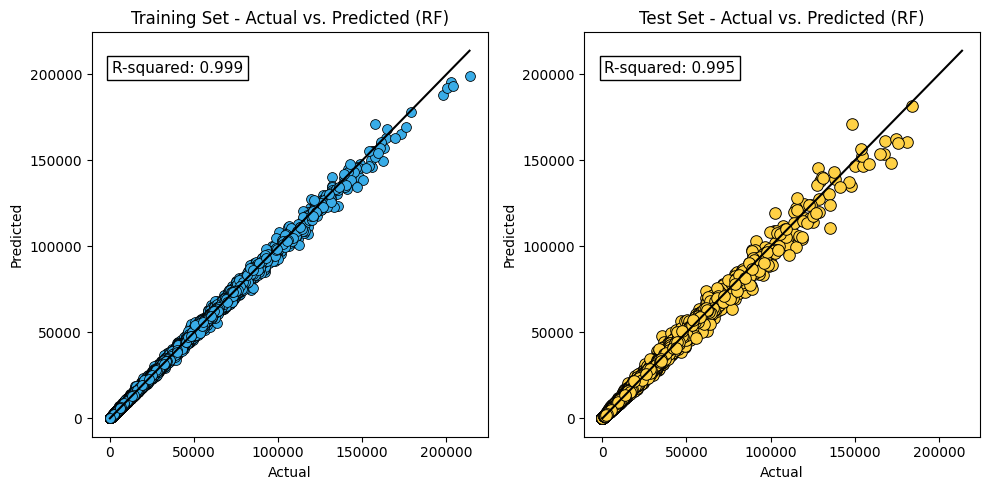

In [26]:

# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [85]:
# Obtain predictions for the test dataset
y_test_pred = model_RF.predict(X_test)

In [86]:
comparison_test_df = pd.DataFrame({'Predicted': y_test_pred, 'Actual': y_test})
comparison_test_df.head()

,Predicted,Actual
case_num,,
588,7905.944103,7782.62
391,2463.340069,2457.39
773,5642.163500,5126.19
775,1461.539027,1467.06
879,10942.997035,10041.70


In [87]:
# Concatenate comparison_df with X_test
concatenated_test_df = pd.concat([X_test, comparison_test_df], axis=1)

concatenated_test_df.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
case_num,,,,,,,,,
588,1.358904,55.671093,1072.948149,322.005237,0.296478,974.812075,21.998831,7905.944103,7782.62
391,6.200000,17.743045,1327.831513,230.685909,0.298417,459.303415,93.661558,2463.340069,2457.39
773,1.528767,91.594717,1210.373574,496.644528,0.243255,763.475551,31.259883,5642.163500,5126.19
775,4.416438,6.324609,1251.987121,329.811040,0.235667,786.512041,38.828670,1461.539027,1467.06
879,1.189041,84.097055,2424.864587,251.993775,0.136780,866.797466,56.402386,10942.997035,10041.70


In [88]:
# Obtain predictions for the training dataset
y_train_pred = model_RF.predict(X_train)

In [89]:
comparison_train_df = pd.DataFrame({'Predicted': y_train_pred, 'Actual': y_train})
comparison_train_df.head()

,Predicted,Actual
case_num,,
207,1334.917542,1325.52
779,32425.678949,31759.10
783,2612.355729,2617.35
638,2127.240878,2130.44
138,1570.055084,1571.16


In [93]:
# Concatenate comparison_df with X_train
concatenated_train_df = pd.concat([X_train, comparison_train_df], axis=1)

concatenated_train_df.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
case_num,,,,,,,,,
207,4.756164,53.430458,1164.225717,210.578313,0.169661,513.893676,34.327362,1334.917542,1325.52
779,0.169863,30.180537,1683.703882,293.308471,0.159314,472.891708,32.006569,32425.678949,31759.10
783,3.227397,42.195767,1491.226913,393.795810,0.232694,521.133493,86.997859,2612.355729,2617.35
638,6.030137,62.283845,1887.808774,276.374370,0.267304,424.747788,53.609024,2127.240878,2130.44
138,4.756164,23.878544,1525.459004,405.047106,0.184826,513.829693,78.662629,1570.055084,1571.16


In [94]:
# Combine the rows of concatenated_train_df and concatenated_test_df
combined_df = pd.concat([concatenated_train_df, concatenated_test_df])

# Reset the index of the combined DataFrame
combined_df = combined_df.reset_index(drop=False)

combined_df.head()

,case_num,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
0,207,4.756164,53.430458,1164.225717,210.578313,0.169661,513.893676,34.327362,1334.917542,1325.52
1,779,0.169863,30.180537,1683.703882,293.308471,0.159314,472.891708,32.006569,32425.678949,31759.10
2,783,3.227397,42.195767,1491.226913,393.795810,0.232694,521.133493,86.997859,2612.355729,2617.35
3,638,6.030137,62.283845,1887.808774,276.374370,0.267304,424.747788,53.609024,2127.240878,2130.44
4,138,4.756164,23.878544,1525.459004,405.047106,0.184826,513.829693,78.662629,1570.055084,1571.16


In [95]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81000 entries, 0 to 80999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case_num      81000 non-null  int64  
 1   years         81000 non-null  float64
 2   Kh_Kv         81000 non-null  float64
 3   inj_rate      81000 non-null  float64
 4   permeability  81000 non-null  float64
 5   porosity      81000 non-null  float64
 6   prod_bhp      81000 non-null  float64
 7   thickness     81000 non-null  float64
 8   Predicted     81000 non-null  float64
 9   Actual        81000 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 6.2 MB


In [ ]:
# Get unique values in the "case_num" column
unique_cases = combined_df['case_num'].unique()

# Initialize an empty DataFrame to store the sorted data
sorted_df = pd.DataFrame()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    case_data = combined_df[combined_df['case_num'] == case]
    # Sort the data based on the "days" column
    sorted_case_data = case_data.sort_values(by="years")
    # Drop the first row from the sorted data
    sorted_case_data = sorted_case_data.drop(sorted_case_data.index[0])
    # Append the sorted data to the overall sorted DataFrame
    sorted_df = sorted_df.append(sorted_case_data, ignore_index=True)

# Print the updated dataset
print(sorted_df)

In [100]:
sorted_df[sorted_df['case_num'] == 0].head()

,case_num,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Predicted,Actual
46720,0,0.084932,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,27407.931440,26614.0
46721,0,0.169863,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,22090.934530,21427.7
46722,0,0.254795,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,20040.597867,18809.7
46723,0,0.339726,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,18397.495707,16676.6
46724,0,0.424658,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,15142.710576,14810.9


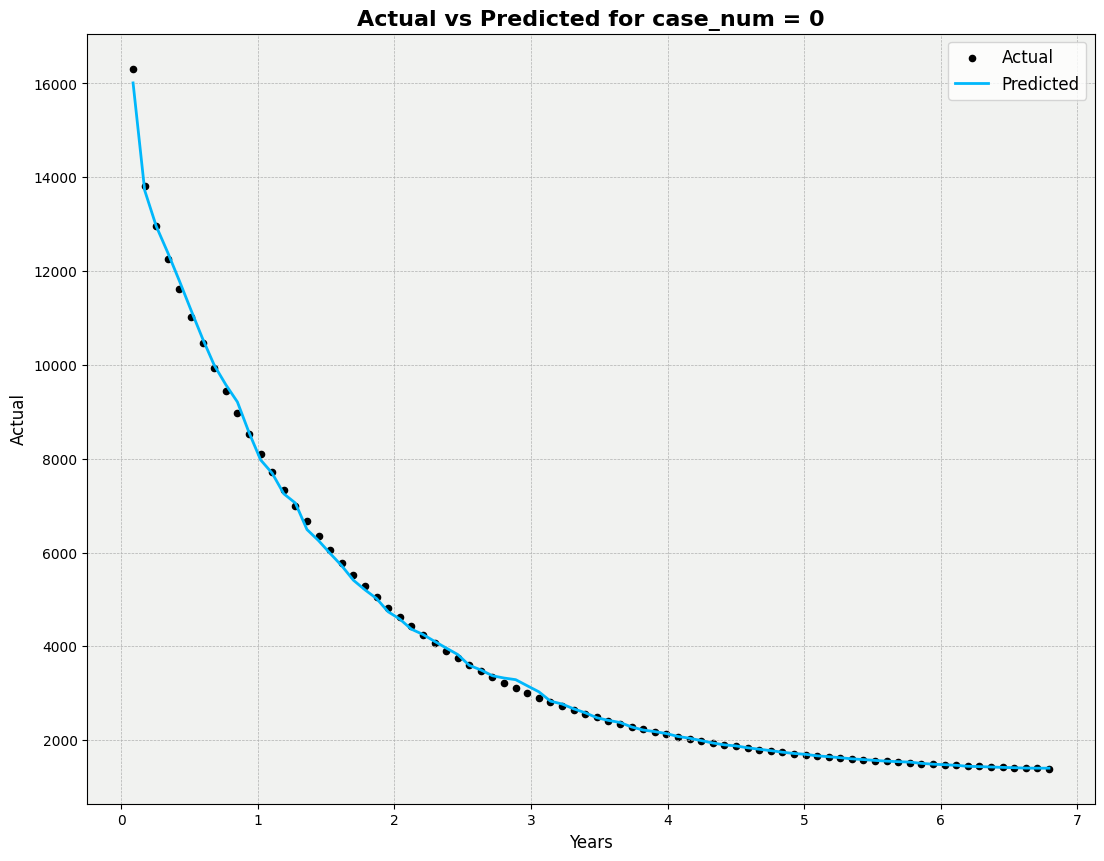

In [104]:
plot_1 = sorted_df[sorted_df['case_num'] == 13]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Actual', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_1['years'], plot_1['Predicted'], color='#00b7fb', linewidth=2, label='Predicted')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Predicted for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper right', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()

#**VALIDATION**

In [161]:
df_validation = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/04_Validation_df.csv')

In [136]:
df_validation.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,2511,6.879452,1790.25,10070500,1740.71,4370930.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,2542,6.964384,1790.18,10126000,1740.71,4424890.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,2573,7.049315,1790.12,10181500,1740.71,4478850.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,2604,7.134247,1790.09,10237000,1740.71,4532810.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,2635,7.219178,1790.07,10292500,1740.71,4586770.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [177]:
df_validation.drop(columns = ['days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category' ], inplace = True)

In [178]:
val_pred = df_validation.copy()

In [179]:
val_pred.set_index('case_num', inplace=True)
val_pred.head()

,years,oil_prod_rate,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,,
0,6.879452,1790.25,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,6.964384,1790.18,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.049315,1790.12,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.134247,1790.09,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.219178,1790.07,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [180]:
val_pred.drop(columns = 'oil_prod_rate', inplace = True)

In [181]:
val_pred.head()

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,
0,6.879452,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,6.964384,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.049315,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.134247,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,7.219178,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [182]:
y_val_pred = model_RF.predict(val_pred)

In [183]:
R2_score = r2_score(df_validation.oil_prod_rate, y_val_pred)
R2_score

0.8258347885747837

In [184]:
val_pred['Actual'] = df_validation.oil_prod_rate
val_pred['Predicted'] = y_val_pred

In [185]:
# Reset the index of the combined DataFrame
val_pred = val_pred.reset_index(drop=False)

In [187]:
check_data = val_pred[val_pred['case_num'] == 11]
check_data.head(10)

,case_num,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Actual,Predicted
352,11,6.879452,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
353,11,6.964384,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
354,11,7.049315,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
355,11,7.134247,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
356,11,7.219178,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
357,11,7.304110,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
358,11,7.389041,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
359,11,7.473973,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
360,11,7.558904,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751
361,11,7.643836,94.802377,1303.609058,112.432627,0.262506,572.300312,14.633538,1789.9,1751.706751


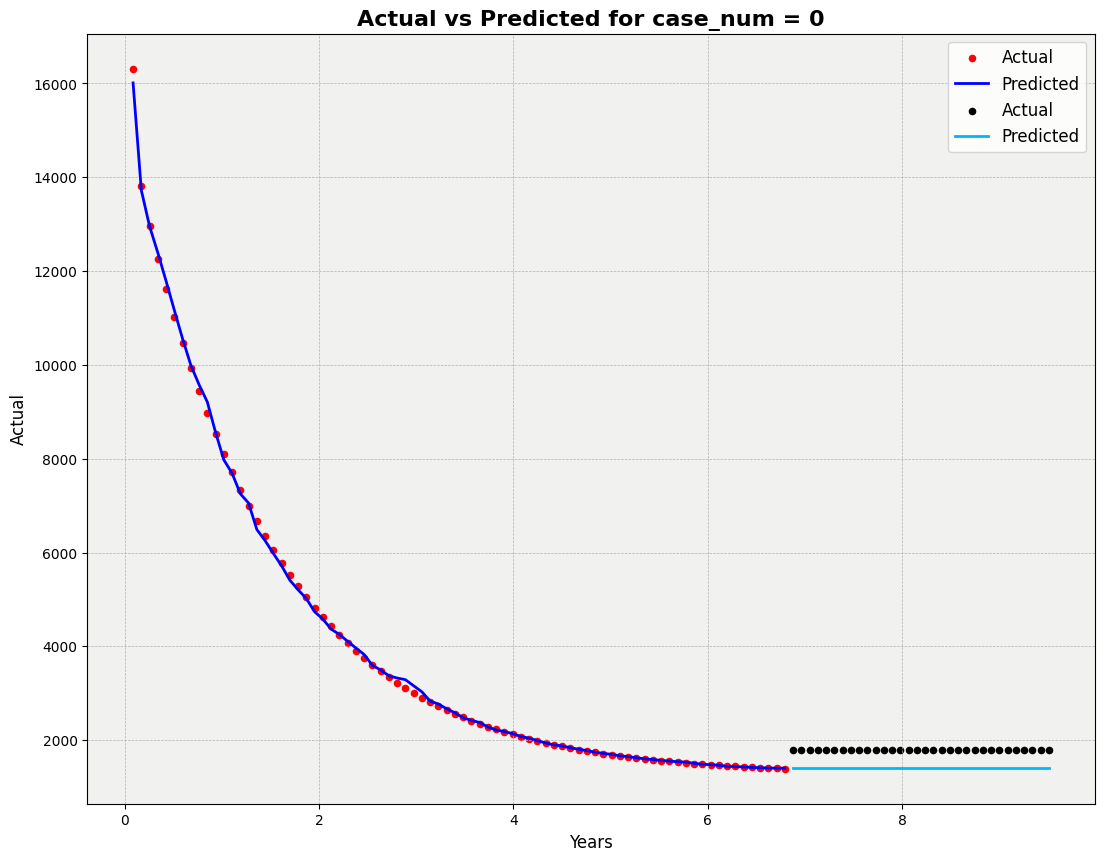

In [209]:
plot_1 = sorted_df[sorted_df['case_num'] == 13]
plot_2 = val_pred[val_pred['case_num'] == 13]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['Actual'], color='red', s=20, label='Actual', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_1['years'], plot_1['Predicted'], color='blue', linewidth=2, label='Predicted')


# Plot scatter for "Actual" column
ax1.scatter(plot_2['years'], plot_2['Actual'], color='black', s=20, label='Actual', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_2['years'], plot_2['Predicted'], color='#00b7fb', linewidth=2, label='Predicted')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Predicted for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper right', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()

In [191]:
Original_data = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/01_df_merged.csv')
riginal_data.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0.000000,0.0,0,0.00,0.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,0.084932,26614.0,825035,1740.71,53962.1,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


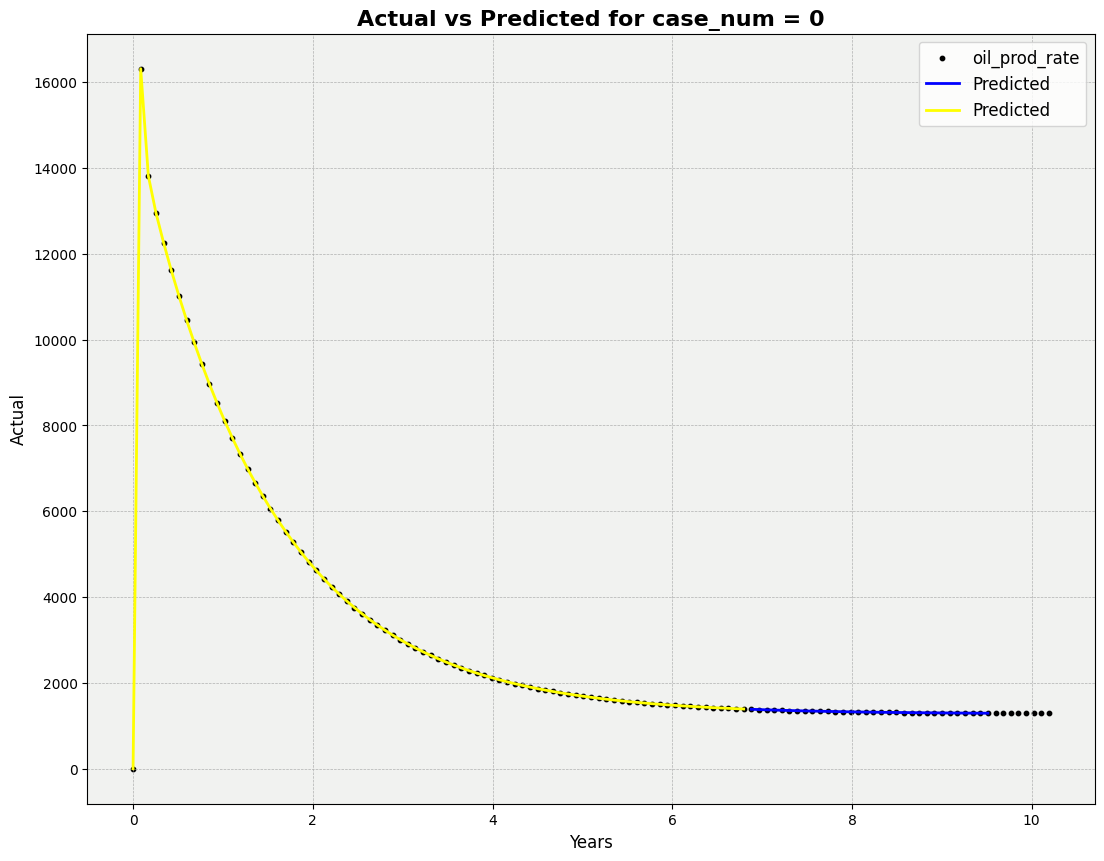

In [206]:
plot_1 = Original_data[Original_data['case_num'] == 13]
plot_2 = df_validation[df_validation['case_num'] == 13]
plot_3 = df_training[df_training['case_num'] == 13]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['oil_prod_rate'], color='black', s=10, label='oil_prod_rate', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_2['years'], plot_2['oil_prod_rate'], color='blue', linewidth=2, label='Predicted')

# Plot line for "Predicted" column
ax1.plot(plot_3['years'], plot_3['oil_prod_rate'], color='yellow', linewidth=2, label='Predicted')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Predicted for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper right', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()